In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color                        # NOTE: additional package generativepy is required (pip)
from PIL import ImageColor

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm

# img_dir = './img/bivariate_maps/'
# if not exists(img_dir):
#     makedirs(img_dir)


# 1. Functions

## 1.1. Prepare DataFrames

In [335]:
def shannon_entropy(row, region_cols):
    values = row[region_cols].to_numpy(dtype=float)
    total = values.sum()

    if total == 0:
        return 0
    
    p = values / total
    p = p[p > 0]  # filter out zero probabilities to avoid log(0)
    entropy = - np.sum(p * np.log(p))

    return entropy


def prepare_gdf(year, level):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlaceRegion/'
    file_extension = '_birthPlaceRegion_sex.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)

    # avoid data type issues
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place_Region'], as_index=False)['Value'].sum()

    # --- REMAP REGIONS INTO SMALLER SET ---
    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Northern Africa': 'MENA',
        'Western Asia': 'MENA',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',

        'Southern Asia': 'Asia',    # still not sure where to place it
    }
    df['Group'] = df['Birth_Place_Region'].map(region_map)
    # df['Group'] = df['Group'].fillna('Other') # assign 'Other' to unmapped regions

    df = df.groupby([level, 'Group'], as_index=False)['Value'].sum()

    # --- DATA PROCESSING SETUP ---
    # pivot table to have regions as columns
    df_wide = df.pivot_table(
        index=level,
        columns='Group',
        values='Value',
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    df_wide.columns.name = None

    # load dataframe with local population
    aux = pd.read_csv(f'../data/birthPlace_spain_v_outside/{year}_birthPlace_spain_v_outside.csv')

    aux['Value'] = pd.to_numeric(aux['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    aux['Birth_Place'] = aux['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    aux = aux.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

    spain = aux[aux['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value': 'Population_Spain'})

    # merge with main dataframe
    df_wide = pd.merge(df_wide, spain, on=level, how='left')

    # remove spanish population from 'Europe' group
    df_wide['Population_Spain'] = df_wide['Population_Spain'].fillna(0)     # set NaN to 0
    df_wide['Europe'] = df_wide['Europe'] - df_wide['Population_Spain']
    df_wide['Europe'] = df_wide['Europe'].clip(lower=0)                     # avoid negative values

    # drop auxiliary column
    df_wide = df_wide.drop(columns=['Population_Spain'])

    # --- CALCULATE METRICS ---
    # total per region
    region_cols = df_wide.drop(columns=[level]).columns
    # region_cols = df_wide.drop(columns=[level, 'Europe']).columns # NOTE: TEST TEST TEST - I STILL HAVE TO REMOVE LOCALS
    df_wide['Total_Immigrants'] = df_wide[region_cols].sum(axis=1)

    # dominant group
    df_wide['Dominant_Group'] = df_wide[region_cols].idxmax(axis=1)
    df_wide['Dominant_Group_Value'] = df_wide[region_cols].max(axis=1)
    df_wide['Dominant_Group_Share'] = (df_wide['Dominant_Group_Value'] / df_wide['Total_Immigrants']).replace([np.inf, np.nan], 0)

    # shannon entropy diversity index
    df_wide['Diversity'] = df_wide.apply(shannon_entropy, args=(region_cols,), axis=1)
    df_wide['Diversity_Norm'] = df_wide['Diversity'] / np.log(len(region_cols))

    # --- MERGE WITH GEOMETRY ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, df_wide, left_on=level, right_on=level, how='left')

    return df



## 1.2. Bivariate Map with Inset Legend

In [336]:
def hex_to_Color(hexcode):
    'convert hex color to Color object'

    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v / 256 for v in rgb]

    return Color(*rgb)


In [337]:
def plot_bivariate_inset(year, level, ax, n_div_bins=5):
    'x: dominant group (categorical)'
    'y: diversity normalized (numerical 0-1)'
    
    all_dominant_groups = ['Africa', 'MENA', 'Latin America', 'Europe', 'NA-AUS-NZ', 'Asia']

    gdf = prepare_gdf(year, level)

    # --- CATEGORICAL X AXIS ---
    group_to_index = {group: idx for idx, group in enumerate(all_dominant_groups)}
    gdf['group_idx'] = gdf['Dominant_Group'].map(group_to_index)

    n_x = len(all_dominant_groups)
    n_y = n_div_bins

    # --- NUMERICAL Y AXIS ---
    # bin edges
    div_bins = np.linspace(0, 1, n_div_bins+1)

    # binning
    gdf['div_bin'] = np.digitize(gdf['Diversity_Norm'], div_bins) - 1

    # clip to valid range
    gdf['div_bin'] = gdf['div_bin'].clip(0, n_div_bins-1)

    # --- GENERATE COLOR MATRIX ---
    # corner colors
    c00 = hex_to_Color('#f3f3f3')
    c10 = hex_to_Color('#e1a800')
    c01 = hex_to_Color('#8997c4')
    c11 = hex_to_Color('#000000')

    # interpolation grid
    color_matrix = []
    for i in range(n_y):
        row = []
        for j in range(n_x):
            # i = immigration axis, j = density axis
            col_low = c00.lerp(c10, j/(n_x-1) if n_x > 1 else 0)
            col_high = c01.lerp(c11, j/(n_x-1) if n_x > 1 else 0)
            col_final = col_low.lerp(col_high, i/(n_y-1) if n_y > 1 else 0)
            row.append(rgb2hex([col_final.r, col_final.g, col_final.b]))
        color_matrix.append(row)

    # --- ASSIGN COLORS ---
    gdf['Color'] = [color_matrix[div_bin][group_idx] for div_bin, group_idx in zip(gdf['div_bin'], gdf['group_idx'])]

    # --- PLOT MAP ---
    gdf.plot(ax=ax, color=gdf["Color"])
    gdf.boundary.plot(ax=ax, color="black", linewidth=0.4)
    ax.axis("off")

    # --- LEGEND AS MATRIX ---
    leg_ax = ax.inset_axes([0.75, 0.05, 0.22, 0.22])
    leg_ax.set_aspect("equal")

    for i in range(n_y):
        for j in range(n_x):
            rect = Rectangle((j, i), 1, 1)
            pc = PatchCollection([rect], facecolor=color_matrix[i][j])
            leg_ax.add_collection(pc)

    leg_ax.set_xlim(0, n_x)
    leg_ax.set_ylim(0, n_y)
    leg_ax.set_xticks(np.arange(n_x) + 0.5)
    leg_ax.set_yticks(np.arange(n_y) + 0.5)

    # labels
    leg_ax.set_xticklabels(all_dominant_groups, rotation=270, ha='right')
    leg_ax.set_yticklabels([f"{v:.2f}" for v in div_bins[:-1]])

    leg_ax.set_xlabel('Dominant Group', fontsize=8)
    leg_ax.set_ylabel('Diversity', fontsize=8)
    leg_ax.tick_params(labelsize=6)

    # --- SCATTER POINTS ON LEGEND ---
    scatter_ax = leg_ax.inset_axes([0, 0, 1, 1], zorder=10)
    scatter_ax.set_xlim(0, n_x)
    scatter_ax.set_ylim(0, n_y)
    scatter_ax.set_xticks([])
    scatter_ax.set_yticks([])

    # transparent background so the legend shows through the scatter points
    scatter_ax.set_facecolor((1,1,1,0)) 

    # accurate placement of scatter points on legend
    norm_x = gdf['group_idx'] + 0.5
    norm_y = gdf['Diversity_Norm'] * n_y
    scatter_ax.scatter(norm_x, norm_y, color='r', s=12, marker='x', alpha=0.9)


In [338]:
# inset legend is not readable when studying Neighborhoods - legend on its own ax (flipped for better space management)

def prepare_bivariate_data(year, level, norm_edges, n_div_bins=5):
    'We want to plot:'
    'x: diversity normalized (numerical 0-1)'
    'y: dominant group (categorical)'

    all_dominant_groups = ['Africa', 'MENA', 'Latin America', 'Europe', 'NA-AUS-NZ', 'Asia']

    gdf = prepare_gdf(year, level)

    # --- CATEGORICAL Y AXIS ---
    group_to_index = {group: idx for idx, group in enumerate(all_dominant_groups)}
    gdf['group_idx'] = gdf['Dominant_Group'].map(group_to_index)

    n_x = n_div_bins
    n_y = len(all_dominant_groups)

    # --- NUMERICAL X AXIS ---
    # bin edges
    # div_bins = np.linspace(0, 1, n_div_bins+1) # --- OLD 0-1 X-AXIS ---
    div_bins = np.quantile(norm_edges, np.linspace(0, 1, n_x+1))



    # binning
    gdf['div_bin'] = np.digitize(gdf['Diversity_Norm'], div_bins) - 1

    # clip to valid range
    gdf['div_bin'] = gdf['div_bin'].clip(0, n_div_bins-1)

    # --- GENERATE COLOR MATRIX ---

    # BREWER BLUE-RED 
    c00 = hex_to_Color('#c6dbef')  # light blue
    c10 = hex_to_Color('#08306b')  # dark navy
    c01 = hex_to_Color('#fee0d2')  # light salmon
    c11 = hex_to_Color('#a50f15')  # dark red

    # CARTO SUNSET-DUSK 
    # c00 = hex_to_Color('#fff2cc')  # soft cream
    # c10 = hex_to_Color('#f57d15')  # deep orange
    # c01 = hex_to_Color('#d2e3f3')  # light powder blue
    # c11 = hex_to_Color('#345ba9')  # deep royal blue

    # interpolation grid
    color_matrix = []
    for i in range(n_y):
        row = []
        for j in range(n_x):
            # i = immigration axis, j = density axis
            col_low = c00.lerp(c10, j/(n_x-1) if n_x > 1 else 0)
            col_high = c01.lerp(c11, j/(n_x-1) if n_x > 1 else 0)
            col_final = col_low.lerp(col_high, i/(n_y-1) if n_y > 1 else 0)
            row.append(rgb2hex([col_final.r, col_final.g, col_final.b]))
        color_matrix.append(row)

    # --- ASSIGN COLORS ---
    gdf['Color'] = [color_matrix[group_idx][div_bin] for div_bin, group_idx in zip(gdf['div_bin'], gdf['group_idx'])]

    # --- STORE METADATA ---
    gdf.attrs['bivariate_metadata'] = {
        'groups': all_dominant_groups,
        'div_bins': div_bins,
        'color_matrix': color_matrix,
        'n_x': n_x,
        'n_y': n_y
    }

    return gdf
    

def plot_bivariate_map(ax, gdf):
    gdf.plot(ax=ax, color=gdf['Color'])
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4)
    ax.axis('off')


def plot_bivariate_legend(ax, gdf):
    metadata = gdf.attrs['bivariate_metadata']

    all_dominant_groups = metadata['groups']
    n_x = metadata['n_x']
    n_y = metadata['n_y']
    div_bins = metadata['div_bins']
    color_matrix = metadata['color_matrix']

    # --- COLOR MATRIX ---
    ax.set_aspect('equal')

    for i in range(n_y):
        for j in range(n_x):
            rect = Rectangle((j, i), 1, 1)
            pc = PatchCollection([rect], facecolor=color_matrix[i][j],
                                 edgecolor='white', linewidth=1)
            ax.add_collection(pc)

    ax.set_xlim(0, n_x)
    ax.set_ylim(0, n_y)

    ax.set_xticks(np.arange(n_x + 1))
    ax.set_yticks(np.arange(n_y) + 0.5)

    ax.set_xticklabels([f"{v:.2f}" for v in div_bins])
    ax.set_yticklabels(all_dominant_groups, rotation=0, ha='right')
    ax.tick_params(labelsize=14)

    # ax.set_xlabel('Diversity', fontsize=12, labelpad=10)
    # ax.set_ylabel('Dominant Group', fontsize=12, labelpad=10)

    # --- SCATTER POINTS ---
    # correct placement of scatter points on legend when x-axis is binned
    def value_to_legend_x(v, bins):
        # identify bin
        idx = np.digitize(v, bins) - 1
        idx = np.clip(idx, 0, len(bins)-2)

        # position inside the bin [0,1]
        left = bins[idx]
        right = bins[idx+1]
        frac = (v - left) / (right - left) if right > left else 0

        # legend x coordinate = bin index + fraction inside bin
        coord = idx + frac

        return coord

    norm_x = [value_to_legend_x(v, div_bins) for v in gdf['Diversity_Norm']]
    # norm_x = gdf['Diversity_Norm'] * n_x # --- OLD 0-1 X-AXIS ---
    norm_y = gdf['group_idx'] + 0.5
    ax.scatter(norm_x, norm_y, facecolor='white', edgecolor='black', linewidth=1.4, s=20, marker='o', alpha=0.9)

    ax.grid(False)


# 2. Plots

In [339]:
# level = 'Neighborhood'

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plot_bivariate_inset(2025, level, ax, n_div_bins=5)

# plt.show()


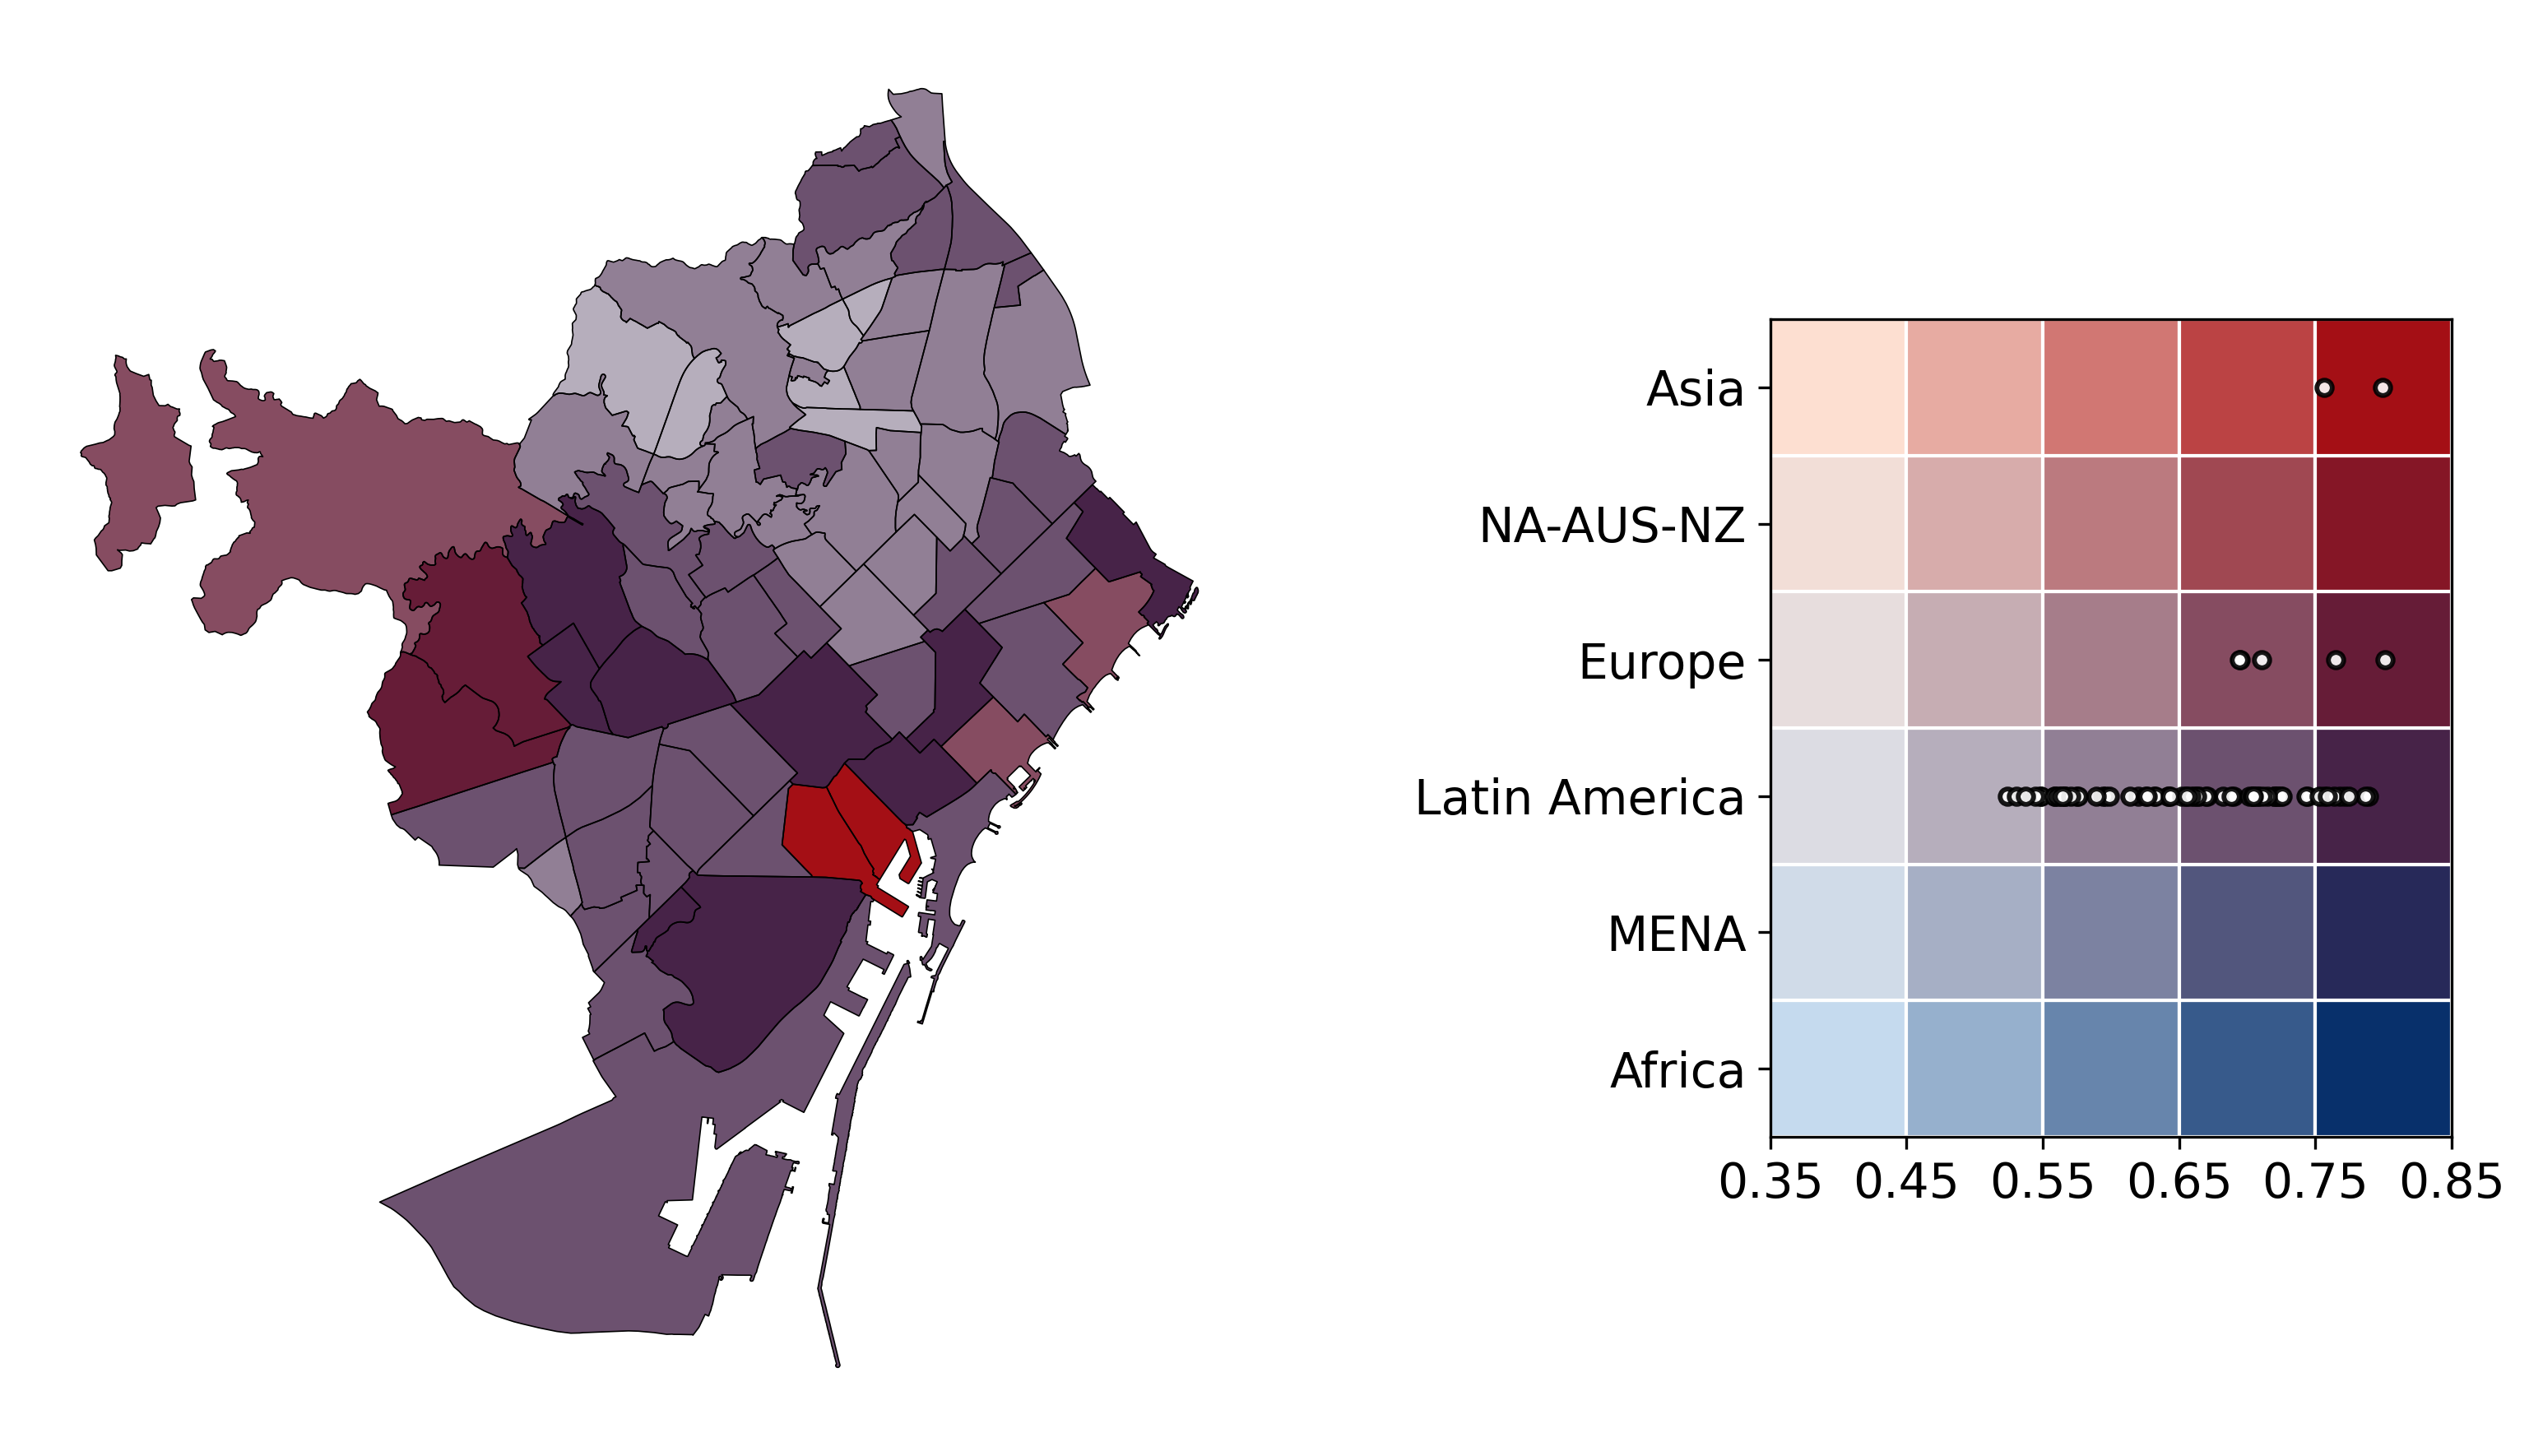

In [340]:
# [0.5, 0.82]
# [0.35, 0.85]
# [0.3, 0.9]
gdf = prepare_bivariate_data(2025, 'Neighborhood', norm_edges=[0.35, .85], n_div_bins=5)

# Create figure with gridspec for custom width ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = plt.GridSpec(1, 2, width_ratios=[3, 1])  # 3:1 ratio = 3/4:1/4

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_bivariate_map(ax1, gdf)
plot_bivariate_legend(ax2, gdf)

plt.tight_layout()
plt.show()


# 3. Diversity

In [341]:
gdf = prepare_gdf(2025, 'Neighborhood')

key_neighborhoods = [
    'el Barri Gòtic',       # high diversity 
    'la Sagrada Família',   # medium diversity
    'Verdun'                # low diversity
]

gdf = gdf[gdf['Neighborhood'].isin(key_neighborhoods)]

# sort by diversity (better visualization)
gdf = gdf.sort_values('Diversity_Norm', ascending=True).reset_index(drop=True)
# display(gdf)

# compute shares for each region
groups = ['Africa', 'Asia', 'Europe', 'Latin America', 'MENA', 'NA-AUS-NZ']
gdf['Total_Immigrants'] = gdf[groups].sum(axis=1)
for col in groups:
    gdf[col + '_share'] = gdf[col] / gdf['Total_Immigrants']



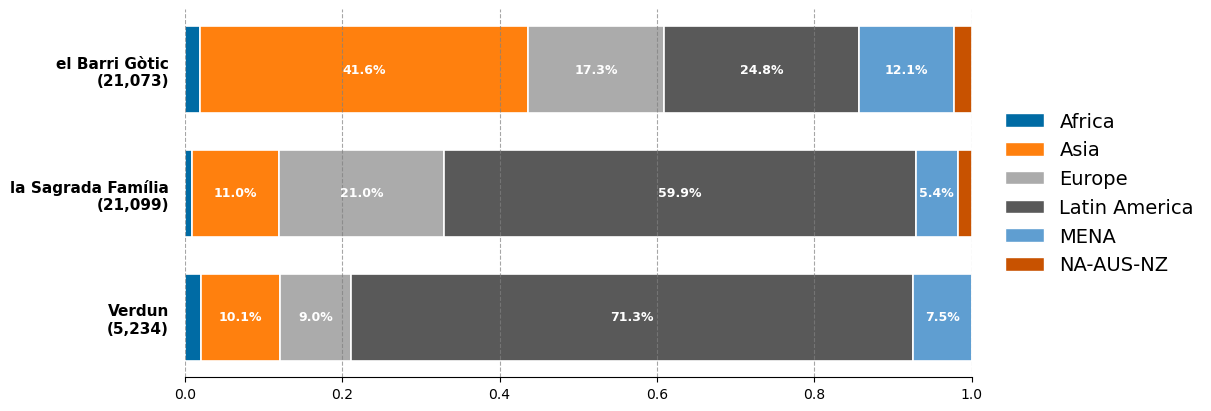

In [342]:
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200']
# colors = plt.cm.cividis(np.linspace(0, 1, 6))

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
indent = np.zeros(len(gdf))

for col, color in zip(groups, colors):
    shares = gdf[col + '_share'].values
    bars = ax.barh(gdf['Neighborhood'], shares, left=indent, color=color, edgecolor='white', linewidth=1.2, height=0.7)

    # labels inside bars only if they fit
    for bar, share in zip(bars, shares):
        if share > 0.05:   # threshold for label visibility
            width = bar.get_width()
            height = bar.get_height()
            ax.text(bar.get_x() + width / 2, bar.get_y() + height / 2,
                    f"{share*100:.1f}%", ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    indent += shares

# grid
ax.grid(axis='x', linestyle='--', alpha=0.7, color='gray')

# x-axis
ax.set_xlim(0, 1)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

# y labels
neighborhood_labels = []
for idx, row in gdf.iterrows():
    label = f'{row["Neighborhood"]}\n({row["Total_Immigrants"]:,})'
    neighborhood_labels.append(label)

ax.set_yticks(range(len(gdf)))
ax.set_yticklabels(neighborhood_labels, fontsize=11, fontweight='bold')
ax.tick_params(axis='y', which='major', pad=8, width=0)

# legend
legend_elements = [Patch(facecolor=color, edgecolor='white', linewidth=1, label=grp) for grp, color in zip(groups, colors)]

legend = ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    frameon=False
)

plt.show()


---
# Testing

In [343]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Define colorblind-friendly palette
# cb_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# # Your data preparation
# gdf = prepare_gdf(2025, 'Neighborhood')
# key_neighborhoods = ['el Barri Gòtic', 'Vallbona', 'Verdun']
# gdf = gdf[gdf['Neighborhood'].isin(key_neighborhoods)]

# # Population groups
# groups = ['Africa', 'Asia', 'Europe', 'Latin America', 'MENA', 'NA-AUS-NZ']

# # Calculate percentages
# total_immigrants = gdf[groups].sum(axis=1)
# percentages = gdf[groups].div(total_immigrants, axis=0) * 100

# # Create enhanced donut charts
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# for idx, (ax, neighborhood) in enumerate(zip(axes, gdf['Neighborhood'])):
#     neighborhood_data = gdf[gdf['Neighborhood'] == neighborhood]
#     values = neighborhood_data[groups].iloc[0]
#     total = neighborhood_data['Total_Immigrants'].iloc[0]
    
#     # Filter out zero values for cleaner visualization
#     non_zero_mask = values > 0
#     plot_values = values[non_zero_mask]
#     plot_groups = np.array(groups)[non_zero_mask]
#     plot_colors = [cb_palette[i] for i in range(len(groups)) if non_zero_mask[i]]
    
#     # Create donut chart
#     wedges, texts, autotexts = ax.pie(plot_values, labels=plot_groups, colors=plot_colors,
#                                       autopct='%1.1f%%', startangle=90,
#                                       wedgeprops=dict(edgecolor='white', linewidth=2))
    
#     # Draw circle in the middle for donut effect
#     centre_circle = plt.Circle((0,0), 0.70, fc='white')
#     ax.add_artist(centre_circle)
    
#     # Enhanced styling
#     for autotext in autotexts:
#         autotext.set_color('white')
#         autotext.set_fontweight('bold')
#         autotext.set_fontsize(10)
    
#     for text in texts:
#         text.set_fontsize(11)
#         text.set_fontweight('bold')
    
#     ax.set_title(f'{neighborhood}\nTotal: {total:,} immigrants', 
#                  fontsize=13, fontweight='bold', pad=20)

# fig.suptitle('Immigrant Population Composition by Neighborhood', 
#              fontsize=16, fontweight='bold', y=1.02)
# plt.tight_layout()
# plt.show()